In [ ]:

#this code reads the dataframe from the saved csv
import pandas as pd 
df = pd.read_csv(
    r"C:\Users\Medi0\Coding_projects\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv",
    index_col=0,
    parse_dates=True
)
print(df)


In [6]:
#Calculating rate of change (RoC) to try and identify trends
df['roc_4h']  = (df['close'] - df['close'].shift(4))  / df['close'].shift(4)
df['roc_24h'] = (df['close'] - df['close'].shift(24)) / df['close'].shift(24)
df['roc_7days'] = (df['close'] - df['close'].shift(168)) / df['close'].shift(168)
df['roc_30days'] = (df['close'] - df['close'].shift(720)) / df['close'].shift(720)






In [ ]:
df

### Understanding if the trends gave me valuable insights

1. Compare Models With and Without the New Features
1.1 Baseline vs. Enriched Models
Create a Baseline Set of features (e.g., your original columns without the newly added trend indicators).

Create an Enriched Set of features (baseline + your new trend features, such as ROC or rolling means).

Train/validate two models on the same dataset:

Model A: Using baseline feature set

Model B: Using enriched feature set

1.2 Time-Series Cross-Validation
Since it’s hourly financial data, you should use time-series splits rather than random splits.

Example with scikit-learn’s TimeSeriesSplit(n_splits=k):

Train on the first segment, validate on the next, move the window forward, etc.

1.3 Compare Metrics
Evaluate both models on the same hold-out or rolling validation sets.

If Model B (with the new features) reliably achieves better performance metrics (e.g., lower MSE, higher R², better directional accuracy), you have evidence that your features add predictive value.

2.1 Tree-Based Methods (Random Forest, XGBoost)
Train a tree-based model (e.g., RandomForestRegressor or XGBRegressor) because these often have built-in or easy-to-get feature importance metrics.

After training, examine model.feature_importances_ (or model.get_booster().get_score() in XGBoost).



SHAP (SHapley Additive exPlanations) is a more advanced interpretability method that can tell you how each feature shifts the prediction on a per-sample basis.

If your ROC or rolling mean features have consistently large positive/negative contributions to the model’s output, you know they’re influential.



### PCA Calculatuion

In [12]:

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


#All features excluding target
all_features = [
    'high',
    'low',
    'open',
    'close',
    'Volume BTC',
    'roc_4h',
    'roc_24h',
    'roc_7days',
    'roc_30days'
]

#Only the new trend features
trend_features = [
    'roc_4h',
    'roc_24h',
    'roc_7days',
    'roc_30days'
]



In [ ]:
#pip install scikit-learn



=== PCA on ALL FEATURES ===
Explained Variance Ratio (per PC): [4.49269466e-01 2.08674759e-01 1.29241823e-01 9.95572989e-02
 6.52995756e-02 4.79466616e-02 5.61340768e-06 4.06124386e-06
 7.41154213e-07]
Cumulative Explained Variance: [0.44926947 0.65794422 0.78718605 0.88674335 0.95204292 0.99998958
 0.9999952  0.99999926 1.        ]


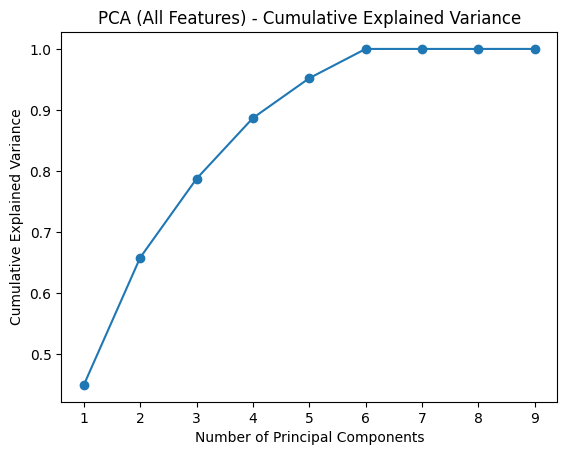


PCA Loadings (All Features):
                 PC1       PC2       PC3       PC4       PC5       PC6  \
high        0.496387  0.005685 -0.034677  0.049601 -0.004038  0.003393   
low         0.496469  0.006155 -0.032660  0.047368 -0.004334  0.003767   
open        0.496421  0.005201 -0.034858  0.047936 -0.005258  0.003146   
close       0.496425  0.006439 -0.033175  0.049055 -0.003400  0.003917   
Volume BTC -0.118313 -0.002758 -0.498025  0.849044 -0.101073  0.082882   
roc_4h     -0.000163  0.400997  0.546233  0.368758  0.590252  0.237586   
roc_24h    -0.002313  0.540587  0.327995  0.170867 -0.585041 -0.478237   
roc_7days  -0.007384  0.572830 -0.269791 -0.254712 -0.255917  0.684582   
roc_30days -0.013763  0.467639 -0.518313 -0.199148  0.483266 -0.489152   

                 PC7       PC8       PC9  
high       -0.633918 -0.121105  0.577373  
low         0.755343  0.087398  0.414675  
open       -0.161208  0.715853 -0.459952  
close       0.040148 -0.682089 -0.532099  
Volume BTC  0.

In [13]:
# 2. PCA on ALL FEATURES
# Create a DataFrame with just the columns of interest and drop NAs
X_all = df[all_features].dropna()

# 2.1 Standardize the data
scaler_all = StandardScaler()
X_all_scaled = scaler_all.fit_transform(X_all)

# 2.2 Run PCA (let n_components=None to get all components)
pca_all = PCA()
pca_all.fit(X_all_scaled)

# 2.3 Explained variance ratio
explained_variances_all = pca_all.explained_variance_ratio_
cumulative_variances_all = np.cumsum(explained_variances_all)

print("\n=== PCA on ALL FEATURES ===")
print("Explained Variance Ratio (per PC):", explained_variances_all)
print("Cumulative Explained Variance:", cumulative_variances_all)

# 2.4 Plot cumulative explained variance
plt.figure()
plt.plot(
    range(1, len(explained_variances_all) + 1),
    cumulative_variances_all,
    marker='o'
)
plt.title('PCA (All Features) - Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# 2.5 PCA loadings (how original features map to each principal component)
loadings_all = pd.DataFrame(
    pca_all.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca_all.components_))],
    index=X_all.columns
)
print("\nPCA Loadings (All Features):")
print(loadings_all)

In [ ]:
'''For PC1, the loadings on high, low, open, and close are all around +0.496.

This means PC1 is essentially the average price level across those four columns (they are highly correlated).

Volume BTC and the roc_* features contribute almost nothing to PC1.

Why? Because high, low, open, and close all move together (when price goes up, they all go up), so one “dimension” can represent that overall level.'
--------------------------------------

Looking at the loadings:

PC2 has large positive loadings on your roc_4h, roc_24h, roc_7days, and roc_30days, and almost no influence from the price columns.

This indicates PC2 is a “trend” or “momentum” dimension, mostly driven by your rate-of-change (ROC) features.

PC3 and PC4 also mix in your roc_* columns but start to incorporate Volume BTC heavily (notice negative or positive loadings of significant magnitude).

So these components seem to capture a combination of momentum and volume fluctuations.


PCs 7, 8, and 9 Add Almost No Extra Variance


'''

In [ ]:
''''
High Correlation Among Price Columns

Since high, low, open, and close cluster strongly, you could potentially drop or combine some of them if you only need a lean set of features (unless your downstream model exploits subtle differences among them).

Distinct “Momentum” Dimension

The rate-of-change features (roc_4h, roc_24h, etc.) clearly capture a separate dimension from raw prices. This suggests they’re adding unique information—useful for forecasting models that rely on momentum signals.

Volume Has Its Own Influence

Volume BTC is prominent in PC3/PC4, meaning it intersects with momentum in some interesting ways—but it does not strongly align with the core “price level” dimension.

Possible Dimensionality Reduction

If you want to reduce from 9 columns to fewer, your first 5 or 6 principal components already capture virtually 100% of the variance.

Alternatively, you might just keep 2–3 PCs if you only need to preserve 80–90% of the variance for, say, a simpler downstream analysis.

However, in predictive modeling, always confirm whether PCA-based reduction actually improves your forecasting performance—some nonlinear models can still benefit from having original features.'
'''


=== PCA on ONLY TREND FEATURES ===
Explained Variance Ratio (per PC): [0.46959517 0.27380158 0.14785254 0.10875071]
Cumulative Explained Variance: [0.46959517 0.74339675 0.89124929 1.        ]


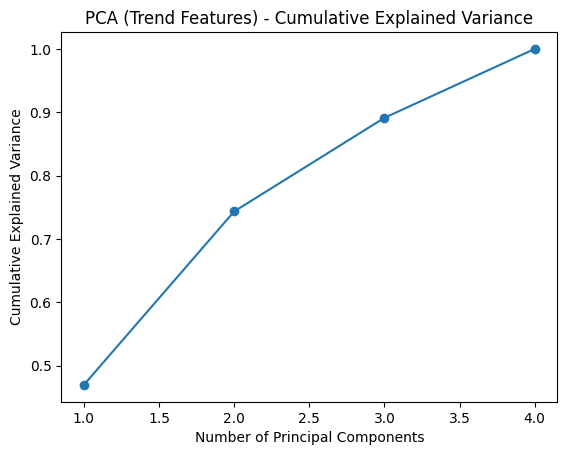


PCA Loadings (Trend Features):
                 PC1       PC2       PC3       PC4
roc_4h      0.400680  0.647172  0.602389  0.240312
roc_24h     0.540366  0.376306 -0.565679 -0.496393
roc_7days   0.572968 -0.344750 -0.284742  0.686861
roc_30days  0.468154 -0.566312  0.485856 -0.473356


In [14]:
# 3. PCA on ONLY the NEW (Trend) FEATURES
X_trend = df[trend_features].dropna()

# 3.1 Standardize the trend data
scaler_trend = StandardScaler()
X_trend_scaled = scaler_trend.fit_transform(X_trend)

# 3.2 Run PCA
pca_trend = PCA()
pca_trend.fit(X_trend_scaled)

# 3.3 Explained variance ratio
explained_variances_trend = pca_trend.explained_variance_ratio_
cumulative_variances_trend = np.cumsum(explained_variances_trend)

print("\n=== PCA on ONLY TREND FEATURES ===")
print("Explained Variance Ratio (per PC):", explained_variances_trend)
print("Cumulative Explained Variance:", cumulative_variances_trend)

# 3.4 Plot cumulative explained variance for trend features only
plt.figure()
plt.plot(
    range(1, len(explained_variances_trend) + 1),
    cumulative_variances_trend,
    marker='o'
)
plt.title('PCA (Trend Features) - Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# 3.5 PCA loadings for trend features
loadings_trend = pd.DataFrame(
    pca_trend.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca_trend.components_))],
    index=X_trend.columns
)
print("\nPCA Loadings (Trend Features):")
print(loadings_trend)

### Statistical analysis
